# NLP 4. Multi_Classification



## 실습 : 머신러닝 모델로 자연어 데이터 분류하기

### 1. 준비

In [1]:
# import
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
# 텐서플로우 제공 데이터셋 다운로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


- numwords : 빈도순으로 사용할 단어의 종류
- test_split : train-test split

### 2. 데이터 확인

In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


- 이미 어느정도 전처리가 되어있다.

In [5]:
type(x_train)

numpy.ndarray

In [6]:
print(y_train[0])
print(y_test[0])

3
3


- 다운받은 뉴스기사들은 정수로 라벨링되어있다.
- 라벨링은 0부터 n까지일 것
- 따라서 라벨의 최대값 + 1 = 클래스의 수

In [7]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


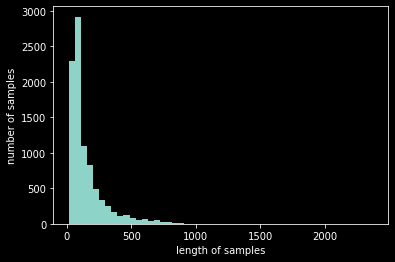

In [8]:
# 데이터(뉴스 기사)의 길이 분포 확인
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.style.use(['dark_background'])

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

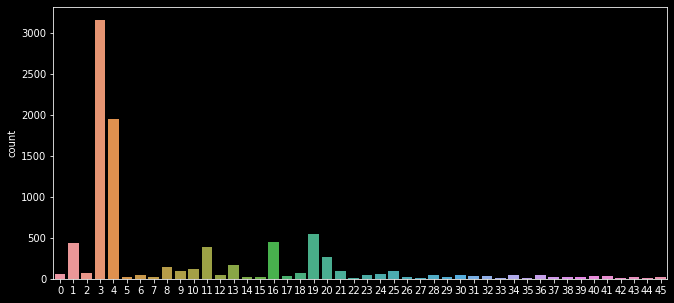

In [9]:
# 클래스별 분포 확인
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

- 특정 클래스에 편중되어있음을 확인할 수 있다.

In [10]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


#### 3.1. 데이터 복원
- 디코딩하여 원본 기사를 확인해본다
- 일반적인 데이터 전처리 과정은 아니며, 학습을 위한 부분

In [11]:
# 데이터의 단어장을 다운로드
word_index = reuters.get_word_index(path="reuters_word_index.json")

565248/550378 [==============================] - 0s 0us/step


In [12]:
# 예시 단어의 맵핑 확인

word_index['the']

1

In [13]:
word_index['it']

13

In [14]:
# +3 해서 원래 매칭된 정수 찾기
# 토큰화 과정에서 처리된 것으로 보인다.
index_to_word = { index+3 : word for word, index in word_index.items() }

In [15]:
print(index_to_word[4])
print(index_to_word[16])

the
it


In [16]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [17]:
# 복원
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


- 전처리된 문장이므로 자연스럽지는 않다.
- \<UNK> 토큰
    > 또는 OOV(Out-Of-Vocabulary)
    >
    > 토큰화된 코퍼스에 없는, 컴퓨터가 모르는 단어. 일괄적으로 언노운 또는 OOV로 표현

In [18]:
for i in [4, 587, 23, 133, 6, 30, 515]:
    print(index_to_word[i])

the
transaction
is
expected
to
be
completed


- 디코딩

In [19]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [20]:

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


- 확인

In [21]:
x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for o

In [22]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

### 3. 백터화

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

- 참조
> 텍스트 데이터가 있을 때, 모델의 입력으로 넣기 위해서는 우선 각 문서를 벡터화할 필요가 있습니다. 항상 그런 것은 아니지만, 일반적으로 텍스트 분류를 할 모델로 인공 신경망을 사용하는 경우, 벡터화 방법 또한 인공 신경망을 사용하는 것이 보편적입니다. Word Embedding, Document Embedding, Contextual Embedding 등의 다양한 벡터화 방법이 존재하는데요.
>
>이번 실습에서는 딥러닝이 아닌 머신러닝 방법을 사용하여 텍스트 분류를 진행할 예정이기 때문에 벡터화 방법도 인공 신경망이 아닌 방법을 사용하겠습니다. 저희가 사용할 벡터화 방법은 Bag of Words 가설을 기반으로 하는 DTM, TF-IDF 행렬입니다.
>
>Bag of Words 가설과 이를 통해 만드는 DTM에 대한 정의는 아래의 링크를 통해 알아보겠습니다.
>
>>https://wikidocs.net/24559

In [24]:
#사이킷런을 통한 DTM 생성
# + 크기확인
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


- num_words의 갯수인 10000개보다 DTM열의 갯수가 적은 이유는 처리 과정에서 추가적 정제가 발생하기 때문이다.

In [25]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


- 이 케이스에서 추가적 전처리가 없다면 TF-IDF는 DTM과 동일한 크기를 갖는다.

### 4. 나이브 베이즈 분류기

In [26]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [27]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [28]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6567230632235085


In [29]:
x_test[3]

'<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the oak hill and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior secured notes semi annual principal payments on the remaining 40 mln dlrs of notes have been satisfied until december 1988 as a result it said the company said the note agreements were amended to reflect an easing of some financial covenants and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the oak hill field reuter 3'

In [30]:
y_test[3]

4

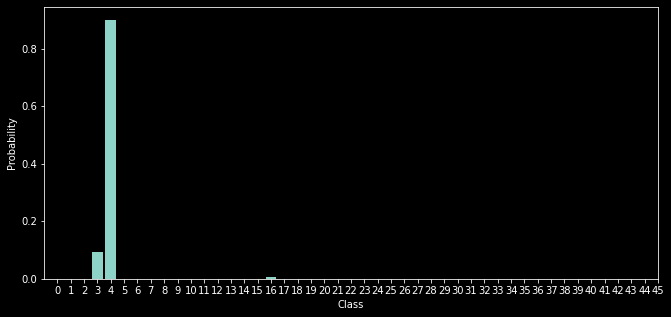

In [31]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [32]:
model.predict(tfidfv_test[3])

array([4])

### 5. F1_Score. Confusion Matrix

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [34]:
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.62      0.69      0.65       105
           2       0.00      0.00      0.00        20
           3       0.81      0.90      0.85       813
           4       0.51      0.96      0.67       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       1.00      0.08      0.15        25
          10       0.00      0.00      0.00        30
          11       0.66      0.63      0.64        83
          12       0.00      0.00      0.00        13
          13       1.00      0.03      0.05        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16       0.69      0.56      0.61        99
          17       0.00    

In [35]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
  df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
  fig = plt.figure(figsize=(12,12))
  heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.ylabel('label')
  plt.xlabel('predicted value')

print('=3')

=3


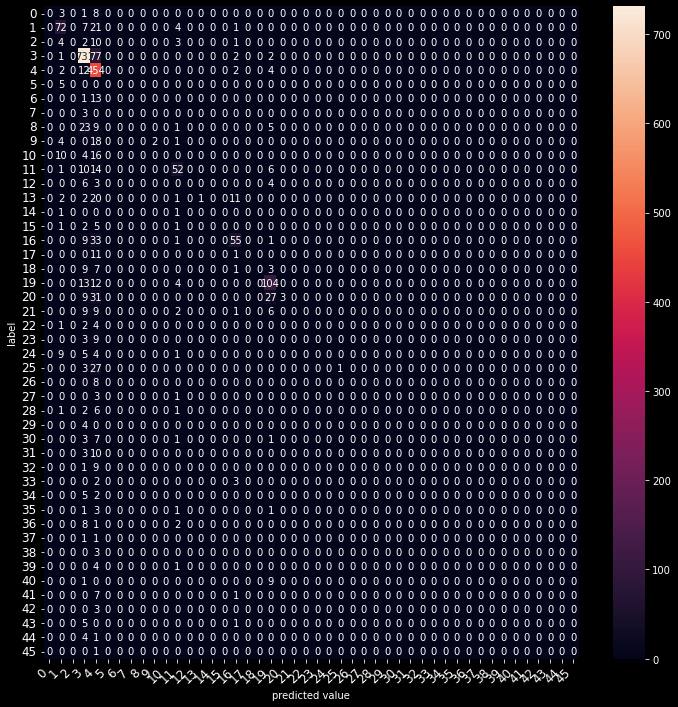

In [36]:
graph_confusion_matrix(model, tfidfv_test, y_test)

### 6. 다양한 모델 사용해보기

#### 6.1. Complement Naive Bayes Classifier(CNB)


In [37]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [38]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


#### 6.2. 로지스틱 회귀

In [39]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=10000)

In [40]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8076580587711487


#### 6.3. 선형 SVM

In [41]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [42]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7715939447907391


#### 6.4. 결정 나무

In [43]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [44]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6202137132680321


#### 6.5. 랜덤 포레스트

In [45]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [46]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.674087266251113


#### 6.6. 그래디언트 부스팅 트리(GradientBoostingClassifier)

- 여러개의 결정나무를 묶어서 앙상블
- 랜덤 포레스트와는 달리 이전 트리의 오차를 보완하는 방식으로, 순차적으로 형성

In [47]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [48]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7662511130899377


#### 6.7. 보팅(Voting)

- 로지스티고히귀, CNB, 그레디언트부스팅트리를 사용하고 소프트보팅
- 소프트보팅은 결과물이 나올 확률값을 가중치처럼 사용해 최종 값을 도출하는 투표 방법이다.

In [49]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [50]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8116651825467498


## 프로젝트 : Vocabulary Size를 변경해서 시도해보기

\+ 딥러닝 모델과 비교해보기

### 0. 라이브러리 버전 확인

In [51]:
import tensorflow
import matplotlib
import seaborn 
import numpy 
import pandas
import sklearn

print(tensorflow.__version__)
print(matplotlib.__version__)
print(seaborn.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(sklearn.__version__)

2.8.0
3.2.2
0.11.2
1.21.5
1.3.5
1.0.2


### 1. 단어수와 모델별 지표의 관계 파악

- 모든 단어 사용 vs 빈도수 상위 5000개 단어 사용
    > 각각의 경우에 대해 앞서 모델들의 지표를 비교해본다.

- 앞서 과정을 모아 TF-IDF 행렬을 생성하는 함수를 정의

In [74]:
def get_tfidf(n_vocb):

    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=n_vocb, test_split=0.2)

    decoded = []
    for i in range(len(x_train)):
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded.append(t)
    x_train = decoded

    decoded = []
    for i in range(len(x_test)):
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded.append(t)
    x_test = decoded

    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)

    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)

    x_test_dtm = dtmvector.transform(x_test) 
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)

    return tfidfv, y_train, tfidfv_test, y_test

#### 1.1. Complement Naive Bayes Classifier(CNB)


- 모든 단어

In [75]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=None)

In [76]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [77]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7649154051647373


- 5000 단어

In [78]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=5000)

In [79]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7707034728406055


#### 1.2. 로지스틱 회귀

- 모든 단어

In [80]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=None)

In [81]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.813446126447017


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


- 5000 단어

In [82]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=5000)

In [83]:
lr = LogisticRegression(C=10000, penalty='l2')
lr.fit(tfidfv, y_train)
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8058771148708815


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


#### 1.3. 선형 SVM

- 모든 단어

In [84]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=None)

In [85]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [86]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7791629563668745


- 5000 단어

In [95]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=5000)

In [96]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
lsvc.fit(tfidfv, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(C=1000, dual=False, max_iter=500, penalty='l1')

In [97]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7715939447907391


#### 1.4. 결정 나무

- 모든 단어 

In [ ]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=None)

In [87]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [88]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6211041852181657


- 5000 단어

In [ ]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=5000)

In [98]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [99]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6179875333926982


#### 1.5. 랜덤 포레스트

- 모든 단어

In [ ]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=None)

In [89]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [90]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.6544968833481746


- 5000 단어

In [ ]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=5000)

In [100]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [101]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.701246660730187


#### 1.6. 그래디언트 부스팅 트리(GradientBoostingClassifier)

- 모든 단어 

In [ ]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=None)

In [91]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [92]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.7702582368655387


- 5000 단어

In [101]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=5000)

In [101]:
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

In [102]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

ValueError: ignored

경사하강법을 수행하기위해서는 최소한의 인풋이 필요한 것으로 보인다

#### 1.7. 보팅(Voting)

- 모든 단어 

In [ ]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=None)

In [93]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 n_jobs=-1, voting='soft')

In [94]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

정확도: 0.8187889581478184


- 5000 단어

In [118]:
tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=5000)

In [ ]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft', n_jobs=-1)
voting_classifier.fit(tfidfv, y_train)

In [ ]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

그레디언트 부스트가 포함되어있으므로 같은 에러가 발생

## 2. 직접 단어 개수를 설정해서 비교

In [106]:
# 앞서 5000, 10000, 전체를 확인해 보았으니 적절한 값들을 추가로 확인.
vocb_list = [1000, 3000, 7000, 9000]

#### 2.1. Complement Naive Bayes Classifier(CNB)


In [107]:
for i in vocb_list:
    tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=i)
    cb = ComplementNB()
    cb.fit(tfidfv, y_train)
    predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print(str(i)+"개 일 때" + "정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

1000개 일 때정확도: 0.7346393588601959
3000개 일 때정확도: 0.7644701691896705
7000개 일 때정확도: 0.7684772929652716
9000개 일 때정확도: 0.7715939447907391


#### 2.2. 로지스틱 회귀

In [109]:
import warnings
 
warnings.filterwarnings("ignore")

In [110]:
for i in vocb_list:
    tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=i)
    lr = LogisticRegression(C=10000, penalty='l2')
    lr.fit(tfidfv, y_train)
    predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print(str(i)+"개 일 때" + "정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

1000개 일 때정확도: 0.780053428317008
3000개 일 때정확도: 0.794746215494212
7000개 일 때정확도: 0.807212822796082
9000개 일 때정확도: 0.8103294746215495


#### 2.3. 선형 SVM

In [111]:
for i in vocb_list:
    tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=i)
    lsvc = LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)
    lsvc.fit(tfidfv, y_train)
    predicted = lsvc.predict(tfidfv_test)
    print(str(i)+"개 일 때" + "정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

1000개 일 때정확도: 0.717720391807658
3000개 일 때정확도: 0.7493321460373998
7000개 일 때정확도: 0.7747105966162066
9000개 일 때정확도: 0.7787177203918076


#### 2.4. 결정 나무

In [112]:
for i in vocb_list:
    tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=i)
    tree = DecisionTreeClassifier(max_depth=10, random_state=0)
    tree.fit(tfidfv, y_train)
    predicted = tree.predict(tfidfv_test) 
    print(str(i)+"개 일 때" + "정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

1000개 일 때정확도: 0.6179875333926982
3000개 일 때정확도: 0.6260017809439002
7000개 일 때정확도: 0.6206589492430988
9000개 일 때정확도: 0.6184327693677649


#### 2.5. 랜덤 포레스트

In [113]:
for i in vocb_list:
    tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=i)
    forest = RandomForestClassifier(n_estimators=5, random_state=0)
    forest.fit(tfidfv, y_train)
    predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print(str(i)+"개 일 때" + "정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

1000개 일 때정확도: 0.707479964381122
3000개 일 때정확도: 0.6856634016028496
7000개 일 때정확도: 0.6736420302760463
9000개 일 때정확도: 0.6874443455031166


#### 2.6. 그래디언트 부스팅 트리(GradientBoostingClassifier)

In [114]:
vocb_list = [7000, 9000]

In [115]:
for i in vocb_list:
    tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=i)
    grbt = GradientBoostingClassifier(random_state=0)
    grbt.fit(tfidfv, y_train)
    predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print(str(i)+"개 일 때" + "정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

7000개 일 때정확도: 0.7604630454140695
9000개 일 때정확도: 0.7684772929652716


#### 2.7. 보팅(Voting)

In [120]:
vocb_list = [9000]

In [ ]:
for i in vocb_list:
    tfidfv, y_train, tfidfv_test, y_test = get_tfidf(n_vocb=i)
    voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
    ], voting='soft', n_jobs=-1)
    voting_classifier.fit(tfidfv, y_train)
    predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
    print(str(i)+"개 일 때" + "정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

## 3. 딥러닝 모델과 비교해보기

- 데이터 불러오기
- 빈도 수는 제한을 두지 않음
- 최대 길이 수를 제한

In [131]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [132]:
len(x_train)

8982

In [133]:
a = [len(i) for i in x_train]
np.array(a)

array([ 87,  56, 139, ...,  77, 119, 105])

In [134]:
np.mean(a)

145.5398574927633

In [135]:
np.std(a)

145.81413013409278

- 8:2로 스플릿 된 x_train에 대해, 문장 길이의 평균과 표준편차를 확인해보았다.
- 문장의 최대 길이를 약 450개로 제한하겠음.
- 로이터 모듈의 load_data 메소드는 maxlen을 하이퍼파라미터로 설정할 수 있다.
    > https://www.tensorflow.org/api_docs/python/tf/keras/datasets/reuters/load_data

In [147]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=None, test_split=0.2, maxlen=450)

In [148]:
len(X_train)

8508

### 3.1.패딩

In [145]:
import tensorflow as tf

In [151]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='pre', 
                                                        maxlen=450)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='pre',
                                                       maxlen=450)

print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')

X_train: (8508, 450)
X_test:  (2127, 450)


In [152]:
X_train[:5]

array([[  0,   0,   0, ...,  15,  17,  12],
       [  0,   0,   0, ..., 505,  17,  12],
       [  0,   0,   0, ...,  11,  17,  12],
       [  0,   0,   0, ..., 222,  17,  12],
       [  0,   0,   0, ..., 156,  17,  12]], dtype=int32)

## 3.2. 검증셋 스플릿

In [154]:
val_len = len(X_train)//5
val_len

1701

In [155]:
X_val = X_train[:val_len]
X_train = X_train[val_len:]

y_val = y_train[:val_len]
y_train = y_train[val_len:]

## 3.3. 모델 구성

In [156]:
vocab_size = 8511   
word_vector_dim = 300

In [157]:
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size,word_vector_dim , input_shape=(None,)))
    model.add(tf.keras.layers.LSTM(16))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [158]:
rnn_model = build_model()

In [159]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         2553300   
                                                                 
 lstm (LSTM)                 (None, 16)                20288     
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,574,005
Trainable params: 2,574,005
Non-trainable params: 0
_________________________________________________________________


In [164]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, verbose=0, mode='auto')

In [165]:
rnn_model_his = rnn_model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks= [early_stopping],
                    verbose=1)

Epoch 1/50
107/107 [==============================] - 3s 29ms/step - loss: -1774.4070 - accuracy: 0.0475 - val_loss: -2450.6475 - val_accuracy: 0.0435
Epoch 2/50
107/107 [==============================] - 3s 24ms/step - loss: -3277.3833 - accuracy: 0.0475 - val_loss: -4296.6465 - val_accuracy: 0.0435
Epoch 3/50
107/107 [==============================] - 2s 23ms/step - loss: -5473.7261 - accuracy: 0.0475 - val_loss: -6892.1304 - val_accuracy: 0.0435
Epoch 4/50
107/107 [==============================] - 2s 23ms/step - loss: -8481.7139 - accuracy: 0.0475 - val_loss: -10364.9814 - val_accuracy: 0.0435
Epoch 5/50
107/107 [==============================] - 2s 23ms/step - loss: -12413.9424 - accuracy: 0.0475 - val_loss: -14838.9404 - val_accuracy: 0.0435
Epoch 6/50
107/107 [==============================] - 2s 23ms/step - loss: -17345.7656 - accuracy: 0.0475 - val_loss: -20334.4590 - val_accuracy: 0.0435
Epoch 7/50
107/107 [==============================] - 2s 23ms/step - loss: -23368.4785 - 

In [166]:
test = rnn_model.evaluate(X_test, y_test, verbose=2)

67/67 - 1s - loss: -2.6629e+04 - accuracy: 0.0461 - 610ms/epoch - 9ms/step


## 4. 마치며



### 기억에 남는 학습 내용
- 복원으로 전처리


### 어려웠던 점
- 딥러닝 모델과 비교.. 모델 구현이 안된다..
- 소프트 보팅 앙상블 모델에서 발생하는 에러의 이유를 모르겠음

### 추가로 해보고 싶은 점
- x


### 총평
> 원본데이터를 보지도 못했고, 봐도 이해하지 못할 것 같고, 구하고 있는 정확도가 뭔지도 명확히 모르겠다... 한국어로 하고싶다..